In [ ]:
!pip install -U torch --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate datasets bitsandbytes triton peft trl \
    bert-score textstat numpy pandas
# ===============================
# ✅ LIMPIEZA DE SALIDA Y VERIFICACIÓN DE VERSIONES
# ===============================
import IPython
IPython.display.clear_output(wait=True)

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 140.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 138.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 155

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Crear carpeta y entrar
!mkdir cochrane_data
%cd cochrane_data

# 2. Inicializar git vacío
!git init

# 3. Agregar remote
!git remote add -f origin https://github.com/feliperussi/bridging-the-gap-in-health-literacy.git

# 4. Activar modo sparse checkout
!git config core.sparseCheckout true

# 5. Indicar SOLO las carpetas que queremos
!echo "data_collection_and_processing/Data Sources/Cochrane/train/pls" >> .git/info/sparse-checkout
!echo "data_collection_and_processing/Data Sources/Cochrane/train/non_pls" >> .git/info/sparse-checkout

# 6. Descargar solo esa parte del repo
!git pull origin main


/content/cochrane_data
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/cochrane_data/.git/
Updating origin
remote: Enumerating objects: 72074, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 72074 (delta 0), reused 2 (delta 0), pack-reused 72071 (from 2)
Receiving objects: 100% (72074/72074), 315.90 MiB | 33.61 MiB/s, done.
Resolving deltas: 100% (2991/2991), done.
From https://github.com/feliperussi/bridging-the-gap-in-health-literacy
 * [new branch]

In [ ]:
from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model
import glob, pandas as pd
import transformers, trl, peft, accelerate, datasets
import bitsandbytes as bnb
import re

In [ ]:
# Número máximo de pares
pares = 2000

# === 1️⃣ Listar archivos ===
pls_files = sorted(glob.glob("data_collection_and_processing/Data Sources/Cochrane/train/pls/*.txt"))
non_pls_files = sorted(glob.glob("data_collection_and_processing/Data Sources/Cochrane/train/non_pls/*.txt"))

# === 2️⃣ Filtrar archivos que contengan 'accumulated' en AMBOS ---
pls_files = [f for f in pls_files if "accumulated" not in os.path.basename(f).lower()]
non_pls_files = [f for f in non_pls_files if "accumulated" not in os.path.basename(f).lower()]

print(f"📚 Total PLS (sin accumulated): {len(pls_files)}")
print(f"📂 Total non-PLS (sin accumulated): {len(non_pls_files)}")

# === 3️⃣ Función para extraer el ID base ===
def extract_id(filename):
    base = os.path.basename(filename)
    match = re.match(r"(.+?)\.pub\d+", base)
    return match.group(1) if match else base.split(".txt")[0]

# === 4️⃣ Diccionarios {id_base: ruta} ===
pls_dict = {extract_id(p): p for p in pls_files}
non_pls_dict = {extract_id(n): n for n in non_pls_files}

# === 5️⃣ Emparejar ===
data = []
for base_id, non_path in non_pls_dict.items():
    if base_id in pls_dict:
        pls_path = pls_dict[base_id]
        with open(pls_path, "r", encoding="utf-8") as f1, open(non_path, "r", encoding="utf-8") as f2:
            data.append({
                "id": base_id,
                "file_pls": os.path.basename(pls_path),
                "file_non_pls": os.path.basename(non_path),
                "pls": f1.read().strip(),
                "non_pls": f2.read().strip()
            })
    if len(data) >= pares:
        break

# === 6️⃣ DataFrame ===
df = pd.DataFrame(data)

# === 7️⃣ Guardar ===
output_path = "cochrane_pairs_clean.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"\n✅ Emparejados {len(df)} pares por nombre base (sin 'accumulated' en ninguno)")
print(f"💾 Guardado en: {output_path}")
df.head(3)



📚 Total PLS (sin accumulated): 4797
📂 Total non-PLS (sin accumulated): 7251

✅ Emparejados 2000 pares por nombre base (sin 'accumulated' en ninguno)
💾 Guardado en: cochrane_pairs_clean.csv


,id,file_pls,file_non_pls,pls,non_pls
0,10.1002-14651858.CD000006,10.1002-14651858.CD000006.pub2-pls.txt,10.1002-14651858.CD000006.pub2-abstract.txt,Absorbable stitches for repair of episiotomy a...,Background\nApproximately 70% of women will ex...
1,10.1002-14651858.CD000009,10.1002-14651858.CD000009.pub4-pls.txt,10.1002-14651858.CD000009.pub4-abstract.txt_se...,Do acupuncture and related therapies help smok...,We included 38 studies. Based on three studies...
2,10.1002-14651858.CD000012,10.1002-14651858.CD000012.pub4-pls.txt,10.1002-14651858.CD000012.pub4-abstract.txt_se...,Alternative versus conventional institutional ...,"Ten trials involving 11,795 women met the incl..."


In [ ]:
df = df.rename(columns={"non_pls": "source", "pls": "target"})

INSTR_PROMPT = """Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the description of the design,
description of study and patient population (age, health condition, gender), and the expected
amount of time a person will be in the study.
4. Results: Answer ‘What were the main results of the study’, include the benefits for the patients,
how the study was relevant for the area of study, and the conclusions from the investigator.
c. Consistency and Replicability: The generated PLS should be consistent regardless of the order of
sentences or the specific phrasing used in the input protocol text.
d. Compliance with Plain Language Guidelines: The generated PLS must follow all these plain
language guidelines:
• Have readability grade level of 6 or below.
• Do not have jargon. All technical or medical words or terms should be defined or broken down
into simple and logical explanations.
• Active voice, not passive.
• Mostly one or two syllable words.
• Sentences of 15 words or less.
• Short paragraphs of 3-5 sentences.
• Simple numbers (e.g., ratios, no percentages).
e. Do not invent Content: The AI model should not invent information. If the AI model includes data
other than the one given in the input abstract, the AI model should guarantee such data is verified and
real.
f. Aim for an approximate PLS length of 500-900 words.

Input abstract:

{source}

Output PLS:
"""

def format_example(row):
    prompt = INSTR_PROMPT.format(source=row["source"])
    return {"prompt": prompt, "response": row["target"]}

# Aplicar la función a cada fila del DataFrame
dataset = df.apply(format_example, axis=1).to_list()

# Crear Dataset de Hugging Face y dividir en train/test
from datasets import Dataset

hf_ds = Dataset.from_list(dataset).train_test_split(test_size=0.1, seed=42)

print(hf_ds)


DatasetDict({
    train: Dataset({
        features: ['prompt', 'response'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['prompt', 'response'],
        num_rows: 200
    })
})


In [ ]:
import random

idx = random.randint(0, len(hf_ds["train"]) - 1)
print(f"🔹 Ejemplo #{idx}")
print(hf_ds["train"][idx]["prompt"])

🔹 Ejemplo #1424
Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the descr

In [ ]:
MODELO="Qwen/Qwen2.5-1.5B-Instruct"
num_train_epochs=4
COSINE_WEIGHT=0      # Desactivado
KL_WEIGHT=0.1        # Activado (foco principal)
READABILITY_WEIGHT=0
COMPLEXITY_WEIGHT=0
base_model_name="Qwen/Qwen2.5-1.5B-Instruct" # teacher para KL

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import warnings
import gc
from dataclasses import dataclass
from transformers import (
    AutoModelForCausalLM, AutoTokenizer, DataCollatorForSeq2Seq,
    BitsAndBytesConfig, AutoModel, TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers.utils import logging

# 0. CONFIGURACIÓN
gc.collect()
torch.cuda.empty_cache()
warnings.filterwarnings("ignore")
logging.set_verbosity_info()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("\n" + "="*80)
print("🚑 MODO RESCATE: ANTI-NAN + DIAGNÓSTICO DE DATOS")
print("="*80)

MODELO = "Qwen/Qwen2.5-1.5B-Instruct"
num_train_epochs = 4
# 🔥 CAMBIO 1: Apagamos KL para la primera prueba. Si esto entrena, el problema era el Teacher.
KL_WEIGHT = 0.0
LEARNING_RATE = 1e-5

# 1. CARGA DE MODELO
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODELO, quantization_config=bnb_config, device_map="auto", trust_remote_code=True
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(MODELO)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 2. LORA
model = prepare_model_for_kbit_training(model)
model.enable_input_require_grads()
peft_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05, # Bajamos R para estabilidad
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM", bias="none"
)
model = get_peft_model(model, peft_config)

# 3. TEACHER (Cargado pero desconectado por ahora si KL=0)
ref_model = AutoModelForCausalLM.from_pretrained(
    MODELO, quantization_config=bnb_config, device_map="auto", trust_remote_code=True
)
ref_model.eval()

# 4. PREPROCESAMIENTO (VERIFICACIÓN DE ETIQUETAS)
def preprocess_function(examples, max_length=1024):
    model_inputs = {"input_ids": [], "attention_mask": [], "labels": [], "source_texts": []}
    for prompt, response in zip(examples["prompt"], examples["response"]):
        if not response: continue

        # Tokenizar
        p_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        r_ids = tokenizer(response, add_special_tokens=False)["input_ids"]

        if len(p_ids) >= max_length: continue
        if len(r_ids) == 0: continue

        # EOS Token
        if r_ids[-1] != tokenizer.eos_token_id: r_ids.append(tokenizer.eos_token_id)

        full_ids = p_ids + r_ids
        if len(full_ids) > max_length:
            full_ids = full_ids[:max_length]
            if len(full_ids) > len(p_ids): full_ids[-1] = tokenizer.eos_token_id

        # Labels: -100 en prompt
        labels = [-100] * len(p_ids) + full_ids[len(p_ids):]
        attention_mask = [1] * len(full_ids)

        # Source text dummy
        src = "text"

        model_inputs["input_ids"].append(full_ids)
        model_inputs["attention_mask"].append(attention_mask)
        model_inputs["labels"].append(labels)
        model_inputs["source_texts"].append(src)
    return model_inputs

print("🔄 Tokenizando...")
tokenized_train = hf_ds["train"].map(preprocess_function, batched=True, remove_columns=hf_ds["train"].column_names)
tokenized_train = tokenized_train.filter(lambda x: len(x['input_ids']) > 0)

# 🔥 DIAGNÓSTICO DE DATOS (IMPORTANTE)
print("\n" + "="*40)
print("🧐 INSPECCIÓN DE DATOS")
sample = tokenized_train[0]
valid_labels = [l for l in sample['labels'] if l != -100]
print(f"Tokens Totales: {len(sample['input_ids'])}")
print(f"Tokens Válidos (Labels): {len(valid_labels)}")
if len(valid_labels) == 0:
    print("❌ ERROR: Tus datos están generando labels vacíos. El modelo recibe todo -100.")
else:
    print("✅ DATOS OK. El modelo tiene qué aprender.")
print("="*40 + "\n")

@dataclass
class DataCollatorWithSourceTexts:
    tokenizer: AutoTokenizer
    def __call__(self, features):
        source_texts = [f.get("source_texts", "") for f in features]
        cleaned = [{k: v for k, v in f.items() if k != "source_texts"} for f in features]
        batch = DataCollatorForSeq2Seq(self.tokenizer, padding=True)(cleaned)
        batch["metadata"] = {"source_texts": source_texts}
        return batch

# 5. LOSS BLINDADA (AQUÍ ESTÁ LA SOLUCIÓN AL NAN)
class CosineAlignedLoss(nn.Module):
    def __init__(self, kl_weight=0, ref_model=None):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index=-100)
        self.kl_weight = kl_weight
        self.ref_model = ref_model

    def forward(self, outputs, labels, inputs=None, **kwargs):
        # 1. Obtener Logits
        logits = outputs.logits

        # 🔥 FIX ANTI-NAN: Convertir a Float32 ANTES de calcular nada
        # BFloat16 puede causar overflow en log_softmax con Gemma
        logits = logits.float()

        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # 2. Cross Entropy Segura
        ce_loss = self.ce(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # 3. KL Divergence Segura
        kl_loss_val = torch.tensor(0.0, device=logits.device)

        if self.kl_weight > 0 and self.ref_model:
            with torch.no_grad():
                ref_out = self.ref_model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                # Teacher logits también a Float32
                ref_logits = ref_out.logits.float()

            # Log Softmax Seguro
            stud_log_probs = F.log_softmax(logits, dim=-1)
            teach_probs = F.softmax(ref_logits, dim=-1)

            kl_loss_val = F.kl_div(stud_log_probs, teach_probs, reduction="batchmean")

            # Última defensa: si KL sale NaN, lo forzamos a 0
            if torch.isnan(kl_loss_val) or torch.isinf(kl_loss_val):
                kl_loss_val = torch.tensor(0.0, device=logits.device)

        total_loss = ce_loss + (self.kl_weight * kl_loss_val)
        return total_loss, ce_loss, kl_loss_val

class CosineAlignedTrainer(Trainer):
    def __init__(self, kl_weight=0, ref_model=None, **kwargs):
        processing_class = kwargs.pop('tokenizer', None)
        super().__init__(processing_class=processing_class, **kwargs)
        self.custom_loss = CosineAlignedLoss(kl_weight=kl_weight, ref_model=ref_model)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        fwd_inputs = {k: v for k, v in inputs.items() if k in ["input_ids", "attention_mask", "labels"]}
        outputs = model(**fwd_inputs)
        loss, ce, kl = self.custom_loss(outputs, inputs["labels"], inputs=fwd_inputs)

        # Log manual
        if self.state.global_step % 1 == 0:
            print(f"Step {self.state.global_step} | Total: {loss.item():.4f} | CE: {ce.item():.4f} | KL: {kl.item():.4f}")
        return (loss, outputs) if return_outputs else loss

# 6. EJECUCIÓN
training_args = TrainingArguments(
    output_dir="gemma_debug",
    per_device_train_batch_size=1, # Obligatorio batch 1 para memoria
    gradient_accumulation_steps=32,
    num_train_epochs=num_train_epochs,
    learning_rate=LEARNING_RATE,
    max_grad_norm=0.5, # Clipping agresivo para evitar NaN
    weight_decay=0.01,
    warmup_steps=5,
    optim="paged_adamw_8bit",
    bf16=True,
    logging_steps=1,
    report_to="none",
    save_strategy="epoch",
    disable_tqdm=False,
    remove_unused_columns=False
)

trainer = CosineAlignedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithSourceTexts(tokenizer),
    kl_weight=KL_WEIGHT,
    ref_model=ref_model
)
model.gradient_checkpointing_enable()

print("\n🚀 INICIANDO ENTRENAMIENTO...")
trainer.train()

print("\n💾 Guardando...")
model.save_pretrained("qwen_result")
tokenizer.save_pretrained("qwen_result")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_


🚑 MODO RESCATE: ANTI-NAN + DIAGNÓSTICO DE DATOS


target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.1,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

Could not locate the custom_generate/generate.py inside Qwen/Qwen2.5-1.5B-Instruct.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.

🔄 Tokenizando...


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/162 [00:00<?, ? examples/s]

PyTorch: setting up devices
Using auto half precision backend
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.



🧐 INSPECCIÓN DE DATOS
Tokens Totales: 1024
Tokens Válidos (Labels): 105
✅ DATOS OK. El modelo tiene qué aprender.


🚀 INICIANDO ENTRENAMIENTO...


skipped Embedding(151936, 1536): 222.5625M params
skipped: 222.5625M params
***** Running training *****
  Num examples = 162
  Num Epochs = 4
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 32
  Total optimization steps = 24
  Number of trainable parameters = 9,232,384


Step 0 | Total: 2.6373 | CE: 2.6373 | KL: 0.0000
Step 0 | Total: 2.4873 | CE: 2.4873 | KL: 0.0000
Step 0 | Total: 1.7406 | CE: 1.7406 | KL: 0.0000
Step 0 | Total: 3.8081 | CE: 3.8081 | KL: 0.0000
Step 0 | Total: 3.8851 | CE: 3.8851 | KL: 0.0000
Step 0 | Total: 3.0783 | CE: 3.0783 | KL: 0.0000
Step 0 | Total: 1.8982 | CE: 1.8982 | KL: 0.0000
Step 0 | Total: 2.2082 | CE: 2.2082 | KL: 0.0000
Step 0 | Total: 3.1277 | CE: 3.1277 | KL: 0.0000
Step 0 | Total: 1.8287 | CE: 1.8287 | KL: 0.0000
Step 0 | Total: 1.5400 | CE: 1.5400 | KL: 0.0000
Step 0 | Total: 2.4898 | CE: 2.4898 | KL: 0.0000
Step 0 | Total: 1.7966 | CE: 1.7966 | KL: 0.0000
Step 0 | Total: 2.6550 | CE: 2.6550 | KL: 0.0000
Step 0 | Total: 6.4866 | CE: 6.4866 | KL: 0.0000
Step 0 | Total: 6.9123 | CE: 6.9123 | KL: 0.0000
Step 0 | Total: 3.6157 | CE: 3.6157 | KL: 0.0000
Step 0 | Total: 2.4431 | CE: 2.4431 | KL: 0.0000
Step 0 | Total: 11.5484 | CE: 11.5484 | KL: 0.0000
Step 0 | Total: 2.0053 | CE: 2.0053 | KL: 0.0000
Step 0 | Total: 2.

Step,Training Loss
1,118.528700
2,107.539600
3,82.570100
4,108.730800
5,105.157600
6,6.245100
7,109.176400
8,104.119400
9,91.820600
10,113.456000


Step 1 | Total: 2.4853 | CE: 2.4853 | KL: 0.0000
Step 1 | Total: 4.7334 | CE: 4.7334 | KL: 0.0000
Step 1 | Total: 2.4430 | CE: 2.4430 | KL: 0.0000
Step 1 | Total: 2.4708 | CE: 2.4708 | KL: 0.0000
Step 1 | Total: 2.3594 | CE: 2.3594 | KL: 0.0000
Step 1 | Total: 17.5465 | CE: 17.5465 | KL: 0.0000
Step 1 | Total: 1.1056 | CE: 1.1056 | KL: 0.0000
Step 1 | Total: 2.6136 | CE: 2.6136 | KL: 0.0000
Step 1 | Total: 3.1453 | CE: 3.1453 | KL: 0.0000
Step 1 | Total: 1.8334 | CE: 1.8334 | KL: 0.0000
Step 1 | Total: 2.8113 | CE: 2.8113 | KL: 0.0000
Step 1 | Total: 3.8134 | CE: 3.8134 | KL: 0.0000
Step 1 | Total: 2.5418 | CE: 2.5418 | KL: 0.0000
Step 1 | Total: 1.7606 | CE: 1.7606 | KL: 0.0000
Step 1 | Total: 2.4955 | CE: 2.4955 | KL: 0.0000
Step 1 | Total: 3.0359 | CE: 3.0359 | KL: 0.0000
Step 1 | Total: 2.4362 | CE: 2.4362 | KL: 0.0000
Step 1 | Total: 1.8320 | CE: 1.8320 | KL: 0.0000
Step 1 | Total: 3.7094 | CE: 3.7094 | KL: 0.0000
Step 1 | Total: 5.4766 | CE: 5.4766 | KL: 0.0000
Step 1 | Total: 2.

Saving model checkpoint to gemma_debug/checkpoint-6
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
  

Step 6 | Total: 2.4344 | CE: 2.4344 | KL: 0.0000
Step 6 | Total: 1.5259 | CE: 1.5259 | KL: 0.0000
Step 6 | Total: 3.8990 | CE: 3.8990 | KL: 0.0000
Step 6 | Total: 2.6515 | CE: 2.6515 | KL: 0.0000
Step 6 | Total: 1.8042 | CE: 1.8042 | KL: 0.0000
Step 6 | Total: 2.2291 | CE: 2.2291 | KL: 0.0000
Step 6 | Total: 4.1221 | CE: 4.1221 | KL: 0.0000
Step 6 | Total: 2.7885 | CE: 2.7885 | KL: 0.0000
Step 6 | Total: 1.4981 | CE: 1.4981 | KL: 0.0000
Step 6 | Total: 1.9613 | CE: 1.9613 | KL: 0.0000
Step 6 | Total: 2.0361 | CE: 2.0361 | KL: 0.0000
Step 6 | Total: 1.9154 | CE: 1.9154 | KL: 0.0000
Step 6 | Total: 1.5448 | CE: 1.5448 | KL: 0.0000
Step 6 | Total: 2.6954 | CE: 2.6954 | KL: 0.0000
Step 6 | Total: 2.4368 | CE: 2.4368 | KL: 0.0000
Step 6 | Total: 2.6104 | CE: 2.6104 | KL: 0.0000
Step 6 | Total: 2.1314 | CE: 2.1314 | KL: 0.0000
Step 6 | Total: 2.1824 | CE: 2.1824 | KL: 0.0000
Step 6 | Total: 1.8546 | CE: 1.8546 | KL: 0.0000
Step 6 | Total: 4.4623 | CE: 4.4623 | KL: 0.0000
Step 6 | Total: 2.29

Saving model checkpoint to gemma_debug/checkpoint-12
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
 

Step 12 | Total: 2.3770 | CE: 2.3770 | KL: 0.0000
Step 12 | Total: 2.5147 | CE: 2.5147 | KL: 0.0000
Step 12 | Total: 2.8512 | CE: 2.8512 | KL: 0.0000
Step 12 | Total: 3.5598 | CE: 3.5598 | KL: 0.0000
Step 12 | Total: 1.9334 | CE: 1.9334 | KL: 0.0000
Step 12 | Total: 2.5054 | CE: 2.5054 | KL: 0.0000
Step 12 | Total: 3.6849 | CE: 3.6849 | KL: 0.0000
Step 12 | Total: 2.1228 | CE: 2.1228 | KL: 0.0000
Step 12 | Total: 2.5435 | CE: 2.5435 | KL: 0.0000
Step 12 | Total: 2.7105 | CE: 2.7105 | KL: 0.0000
Step 12 | Total: 2.5948 | CE: 2.5948 | KL: 0.0000
Step 12 | Total: 3.6953 | CE: 3.6953 | KL: 0.0000
Step 12 | Total: 10.8416 | CE: 10.8416 | KL: 0.0000
Step 12 | Total: 2.0174 | CE: 2.0174 | KL: 0.0000
Step 12 | Total: 3.1377 | CE: 3.1377 | KL: 0.0000
Step 12 | Total: 17.3391 | CE: 17.3391 | KL: 0.0000
Step 12 | Total: 12.2528 | CE: 12.2528 | KL: 0.0000
Step 12 | Total: 2.8455 | CE: 2.8455 | KL: 0.0000
Step 12 | Total: 3.7781 | CE: 3.7781 | KL: 0.0000
Step 12 | Total: 2.0973 | CE: 2.0973 | KL: 0

Saving model checkpoint to gemma_debug/checkpoint-18
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
 

Step 18 | Total: 3.6113 | CE: 3.6113 | KL: 0.0000
Step 18 | Total: 2.6285 | CE: 2.6285 | KL: 0.0000
Step 18 | Total: 2.0411 | CE: 2.0411 | KL: 0.0000
Step 18 | Total: 1.0648 | CE: 1.0648 | KL: 0.0000
Step 18 | Total: 2.9289 | CE: 2.9289 | KL: 0.0000
Step 18 | Total: 2.3560 | CE: 2.3560 | KL: 0.0000
Step 18 | Total: 2.8110 | CE: 2.8110 | KL: 0.0000
Step 18 | Total: 1.7637 | CE: 1.7637 | KL: 0.0000
Step 18 | Total: 2.2415 | CE: 2.2415 | KL: 0.0000
Step 18 | Total: 2.6291 | CE: 2.6291 | KL: 0.0000
Step 18 | Total: 2.2798 | CE: 2.2798 | KL: 0.0000
Step 18 | Total: 1.5697 | CE: 1.5697 | KL: 0.0000
Step 18 | Total: 1.4966 | CE: 1.4966 | KL: 0.0000
Step 18 | Total: 1.8671 | CE: 1.8671 | KL: 0.0000
Step 18 | Total: 2.5857 | CE: 2.5857 | KL: 0.0000
Step 18 | Total: 2.0545 | CE: 2.0545 | KL: 0.0000
Step 18 | Total: 2.4964 | CE: 2.4964 | KL: 0.0000
Step 18 | Total: 2.4456 | CE: 2.4456 | KL: 0.0000
Step 18 | Total: 3.1110 | CE: 3.1110 | KL: 0.0000
Step 18 | Total: 2.9714 | CE: 2.9714 | KL: 0.0000


Saving model checkpoint to gemma_debug/checkpoint-24
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
 


💾 Guardando...


chat template saved in qwen_result/chat_template.jinja
tokenizer config file saved in qwen_result/tokenizer_config.json
Special tokens file saved in qwen_result/special_tokens_map.json


('qwen_result/tokenizer_config.json',
 'qwen_result/special_tokens_map.json',
 'qwen_result/chat_template.jinja',
 'qwen_result/vocab.json',
 'qwen_result/merges.txt',
 'qwen_result/added_tokens.json',
 'qwen_result/tokenizer.json')

In [ ]:
print(f"Dataset original size:")
print(f"   Train: {len(hf_ds['train'])}")
print(f"   Test: {len(hf_ds['test'])}")

Dataset original size:
   Train: 1800
   Test: 200


In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
print(logs.head())

       loss  grad_norm  learning_rate     epoch  step  train_runtime  \
0  118.5287  89.654404       0.000000  0.197531     1            NaN   
1  107.5396  64.302963       0.000002  0.395062     2            NaN   
2   82.5701  47.223557       0.000004  0.592593     3            NaN   
3  108.7308  70.788849       0.000006  0.790123     4            NaN   
4  105.1576  83.138992       0.000008  0.987654     5            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN                     NaN         NaN         NaN  
1                       NaN                     NaN         NaN         NaN  
2                       NaN                     NaN         NaN         NaN  
3                       NaN                     NaN         NaN         NaN  
4                       NaN                     NaN         NaN         NaN  


⚠️ No hay columna eval_loss en logs


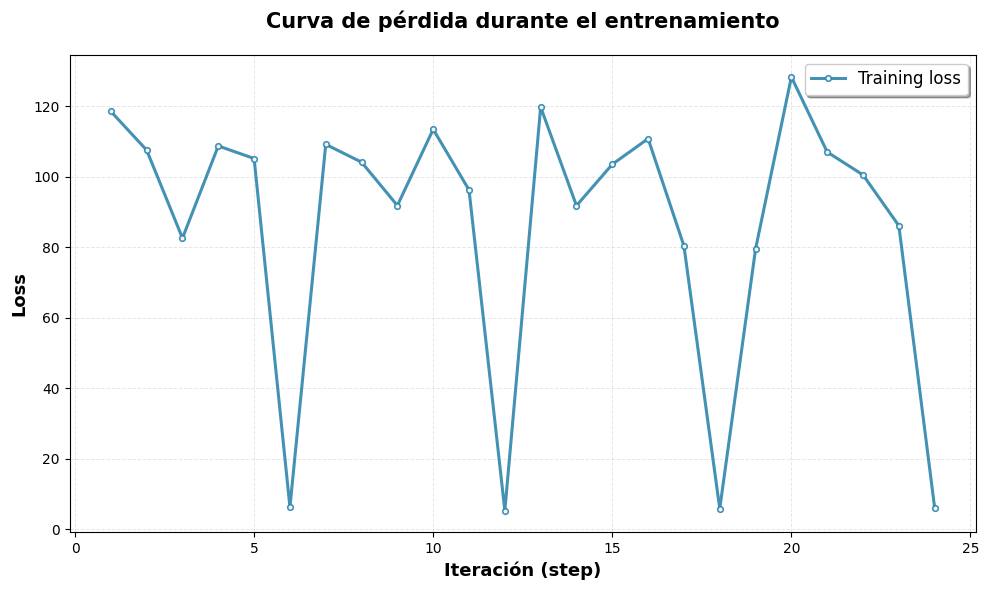

✅ Training points: 24


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Training Loss
# -------------------------
train_mask = logs["loss"].notna() & logs["step"].notna()
steps_train = logs.loc[train_mask, "step"].values
loss_train = logs.loc[train_mask, "loss"].values

# -------------------------
# Eval Loss (si existe)
# -------------------------
if "eval_loss" in logs.columns:
    eval_mask = logs["eval_loss"].notna() & logs["step"].notna()
    steps_eval = logs.loc[eval_mask, "step"].values
    loss_eval = logs.loc[eval_mask, "eval_loss"].values
else:
    steps_eval, loss_eval = [], []
    print("⚠️ No hay columna eval_loss en logs")


plt.figure(figsize=(10, 6))

# === TRAINING ===
plt.plot(
    steps_train, loss_train,
    label="Training loss",
    linewidth=2.2,
    color='#2E86AB',
    alpha=0.9,
    marker='o',
    markersize=4,
    markerfacecolor='white',
    markeredgewidth=1.2,
    markeredgecolor='#2E86AB'
)

# === EVAL ===
if len(steps_eval) > 0:
    plt.plot(
        steps_eval, loss_eval,
        label="Eval loss",
        linewidth=2.2,
        color='#E74C3C',
        alpha=0.9,
        marker='s',
        markersize=4,
        markerfacecolor='white',
        markeredgewidth=1.2,
        markeredgecolor='#E74C3C'
    )

plt.xlabel("Iteración (step)", fontsize=13, fontweight='bold')
plt.ylabel("Loss", fontsize=13, fontweight='bold')
plt.title("Curva de pérdida durante el entrenamiento", fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

print(f"✅ Training points: {len(steps_train)}")
if len(steps_eval) > 0:
    print(f"🔍 Eval points: {len(steps_eval)}")


In [ ]:
import os
from google.colab import drive

# 0. Asegurar que Drive está montado
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 1. Configuración de nombres
LOCAL_PATH = "gemma_final_adapter"  # Carpeta temporal en Colab
DRIVE_PATH = "/content/drive/MyDrive/qwen_models" # Carpeta organizada en tu Drive
VERSION = "v1_A100_BF16_Qwen2.5_2B_KL005_Epoch4"  # Nombre descriptivo de esta prueba

# 2. Guardar Modelo y Tokenizer localmente
print(f"💾 Guardando localmente en '{LOCAL_PATH}'...")
trainer.model.save_pretrained(LOCAL_PATH)
tokenizer.save_pretrained(LOCAL_PATH)

# 3. Copiar a Google Drive
print(f"🚀 Copiando a Drive en: {DRIVE_PATH}/adapter_{VERSION} ...")

# Crear carpeta en drive si no existe
!mkdir -p {DRIVE_PATH}

# Copiar recursivamente (-r) la carpeta local a la carpeta versionada en Drive
!cp -r {LOCAL_PATH} {DRIVE_PATH}/adapter_{VERSION}

print(f"✅ ¡ÉXITO! Tu modelo está seguro en Drive como: adapter_{VERSION}")

💾 Guardando localmente en 'gemma_final_adapter'...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct/snapshots/989aa7980e4cf806f80c7fef2b1adb7bc71aa306/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "dtype": "bfloat16",
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_

🚀 Copiando a Drive en: /content/drive/MyDrive/qwen_models/adapter_v1_A100_BF16_Qwen2.5_2B_KL005_Epoch4 ...
✅ ¡ÉXITO! Tu modelo está seguro en Drive como: adapter_v1_A100_BF16_Qwen2.5_2B_KL005_Epoch4


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os
from google.colab import drive

# 0. Montar Drive (si no está montado aún)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# ==========================================
# CONFIGURACIÓN
# ==========================================
BASE_MODEL = "Qwen/Qwen2.5-1.5B-Instruct"

# ⚠️ OJO: Reemplaza esto con el nombre exacto de la carpeta que creamos en el paso anterior.
# Debería ser algo como: .../gemma_models/adapter_v1_A100_BF16...
ADAPTER_PATH = "/content/drive/MyDrive/qwen_models/adapter_v1_A100_BF16_Qwen2.5_2B_KL005_Epoch4"

# ==========================================
# 1. CARGAR MODELO BASE
# ============================================================================
print(f"📥 Cargando modelo base: {BASE_MODEL}...")

# Usamos la misma config de bits para que sea rápido y ligero
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # Mantenemos BFloat16 de la A100
    bnb_4bit_use_double_quant=True,
)

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# ==========================================
# 2. CARGAR TOKENIZER
# ============================================================================
# Intentamos cargar el tokenizer desde el adapter (si lo guardaste), sino del base
try:
    tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH)
except:
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

tokenizer.pad_token = tokenizer.eos_token

# ==========================================
# 3. INYECTAR EL LORA (PEFT)
# ============================================================================
print(f"🔗 Fusionando adaptador desde: {ADAPTER_PATH}...")
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)

# Poner en modo evaluación para probar
model.eval()

print("✅ ¡Modelo cargado exitosamente!")

# ==========================================
# 4. PRUEBA RÁPIDA
# ============================================================================
prompt = "Input abstract: The feline consumed the rodent. Output PLS:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        use_cache=True,
        do_sample=True,
        temperature=0.7
    )

print("\n🤖 Resultado:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Mounted at /content/drive
📥 Cargando modelo base: Qwen/Qwen2.5-1.5B-Instruct...


PackageNotFoundError: No package metadata was found for bitsandbytes

In [ ]:
# 1. El mismo template gigante que usaste en el entrenamiento
INSTR_PROMPT = """Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the description of the design,
description of study and patient population (age, health condition, gender), and the expected
amount of time a person will be in the study.
4. Results: Answer ‘What were the main results of the study’, include the benefits for the patients,
how the study was relevant for the area of study, and the conclusions from the investigator.
c. Consistency and Replicability: The generated PLS should be consistent regardless of the order of
sentences or the specific phrasing used in the input protocol text.
d. Compliance with Plain Language Guidelines: The generated PLS must follow all these plain
language guidelines:
• Have readability grade level of 6 or below.
• Do not have jargon. All technical or medical words or terms should be defined or broken down
into simple and logical explanations.
• Active voice, not passive.
• Mostly one or two syllable words.
• Sentences of 15 words or less.
• Short paragraphs of 3-5 sentences.
• Simple numbers (e.g., ratios, no percentages).
e. Do not invent Content: The AI model should not invent information. If the AI model includes data
other than the one given in the input abstract, the AI model should guarantee such data is verified and
real.
f. Aim for an approximate PLS length of 500-900 words.

Input abstract:

{source}

Output PLS:
"""

# 2. Tu texto de prueba
test_abstract = "The feline consumed the rodent."

# 3. Construir el prompt real
full_prompt = INSTR_PROMPT.format(source=test_abstract)

# 4. Inferencia
inputs = tokenizer(full_prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        use_cache=True,
        do_sample=True,
        temperature=0.6,
        top_p=0.9
    )

print("\n🤖 Resultado Qwen:")
# Decodificamos cortando la entrada para ver solo la respuesta
print(tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True))


🤖 Resultado Qwen:
Plain Title:
Feline Rodent Consumption Study

Rationale:
Background: Felines are naturally curious animals who often consume small rodents as prey. This curiosity can lead to accidental ingestion of harmful substances if the cat's sense of smell is compromised due to illness or other factors. Understanding the behavior of cats towards rodents is crucial for preventing accidents and ensuring the safety of both pets and humans in households where cats live. The study aims to investigate how cats perceive and react to different odors associated with rodents, particularly focusing on the role of olfactory cues and the impact of human intervention during feeding sessions.

Trial Design:
This study involves observing feline reactions to various odors emitted by rats while the rats are placed inside a transparent container. The researchers monitor the cats' responses through video cameras positioned at strategic angles to capture detailed facial expressions and body languag

In [ ]:
print(hf_ds["test"].column_names)
df_test = hf_ds["test"].to_pandas()
print(df_test.columns)

import re
import pandas as pd

def extract_source_from_prompt(prompt):
    """
    Extrae el texto entre 'original text' y 'simplified text' del prompt.
    Robusto ante espacios, mayúsculas y saltos de línea.
    """
    match = re.search(
        r"Input abstract:\s*[:\-–]?\s*(.*?)\s*Output PLS",
        prompt,
        re.IGNORECASE | re.DOTALL
    )
    if match:
        return match.group(1).strip()
    return ""

# Crear columna 'source' desde 'prompt'
df_test["source"] = df_test["prompt"].apply(extract_source_from_prompt)

# Mantener solo columnas necesarias
df_test = df_test[["source", "response"]]

# Mostrar ejemplo de verificación
print(df_test.head(2))

['prompt', 'response']
Index(['prompt', 'response'], dtype='object')
                                              source  \
0  Background\nPeriodic fever, aphthous stomatiti...   
1  Background\nMemory problems are a common cogni...   

                                            response  
0  Tonsillectomy for PFAPA syndrome (a rare cause...  
1  Cognitive rehabilitation for memory deficits a...  


In [ ]:
if "trainer" in locals() and hasattr(trainer, "model"):
    fine_tuned_model = trainer.model.eval()
else:
    fine_tuned_model = model.eval()

In [ ]:
import gc
import torch
import re
from tqdm import tqdm
from difflib import SequenceMatcher
import pandas as pd

def generate_simplifications_v2(
    df: pd.DataFrame,
    model,
    tokenizer,
    instr_prompt: str,
    batch_size: int = 4,  # Subido a 4 para A100 (puedes bajar a 2 si hay OOM)
    max_source_tokens: int = 1024, # Aumentado para aprovechar contexto de Gemma
    sim_threshold: float = 0.75,
    verbose: bool = True,
):
    """
    Genera textos simplificados con estrategia de recuperación (Fallback).
    1. Intenta generación estándar (L1).
    2. Si sale vacío -> Reintenta con temperatura alta (L2) o Beam Search (L3).
    3. Si es una copia del input -> Reintenta para forzar paráfrasis.
    """

    # Configuración del Tokenizer para generación
    tokenizer.padding_side = "left" # IMPORTANTE: Para generación batched, left padding es mejor
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.clean_up_tokenization_spaces = True

    # Configuración del Modelo
    model.eval()
    model.config.use_cache = True

    # Limpieza inicial
    torch.cuda.empty_cache()
    gc.collect()

    if verbose:
        print("\n🚀 Generación iniciada (Modo Seguro A100)...")

    # === FUNCIONES AUXILIARES INTERNAS ===

    def truncate_text(text, max_tokens=max_source_tokens):
        """Corta el texto del centro si es demasiado largo para el prompt."""
        tokens = text.split() # Aproximación rápida por espacios
        if len(tokens) <= max_tokens:
            return text
        head = tokens[:max_tokens // 2]
        tail = tokens[-max_tokens // 2:]
        return " ".join(head + ["[...]"] + tail)

    def safe_generate(prompts, gen_params):
        """Genera sin calcular gradientes."""
        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048 # Contexto total permitido
        ).to(model.device)

        with torch.inference_mode():
            outputs = model.generate(**inputs, **gen_params)

        # Decodificar solo los nuevos tokens generados (cortando el prompt de entrada)
        # Nota: model.generate devuelve input + output. Cortamos el input.
        input_len = inputs.input_ids.shape[1]
        generated_tokens = outputs[:, input_len:]

        texts = tokenizer.batch_decode(
            generated_tokens,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )
        return texts

    def extract_simplified_text(text):
        """Limpia el texto generado."""
        # Si el modelo repite el prompt, intentamos buscar la etiqueta de salida
        match = re.search(r"Output PLS\s*[:\-–]?\s*(.*)", text, re.IGNORECASE | re.DOTALL)
        if match:
            simplified = match.group(1).strip()
        else:
            simplified = text.strip()

        # Limpieza extra de artefactos
        simplified = re.sub(r"<\|endoftext\|>", "", simplified)
        simplified = re.sub(r"\s+", " ", simplified).strip()
        return simplified

    # === PARÁMETROS DE GENERACIÓN (Niveles de Creatividad) ===

    # L1: Estándar (Conservador)
    GEN_PARAMS_L1 = {
        "max_new_tokens": 512,
        "temperature": 0.6,
        "top_p": 0.9,
        "do_sample": True,
        "repetition_penalty": 1.1,
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.pad_token_id
    }

    # L2: Creativo (Para romper bloqueos/vacíos)
    GEN_PARAMS_L2 = {
        "max_new_tokens": 512,
        "temperature": 1.2,
        "top_p": 0.95,
        "do_sample": True,
        "repetition_penalty": 1.0, # Sin penalización para fluidez
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.pad_token_id
    }

    # L3: Beam Search (Búsqueda exhaustiva, más lento)
    GEN_PARAMS_L3 = {
        "max_new_tokens": 512,
        "num_beams": 3,
        "do_sample": False,
        "repetition_penalty": 1.2,
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.pad_token_id
    }

    # === PREPARACIÓN DATOS ===
    df = df.copy()
    # Aseguramos que la columna source existe
    if "source" not in df.columns:
        raise ValueError("El DataFrame debe tener una columna llamada 'source'")

    df["source_for_generation"] = df["source"].apply(lambda x: truncate_text(str(x)))

    # === BUCLE PRINCIPAL ===
    generated_texts = []
    is_copy_list = []
    was_regenerated_list = []
    regeneration_level_list = []
    similarity_scores = []

    # Iterar por lotes
    for i in tqdm(range(0, len(df), batch_size), desc="Generando..."):
        # Limpieza de memoria periódica
        if i % 20 == 0:
            torch.cuda.empty_cache()
            gc.collect()

        # Preparar lote
        batch_sources = df["source"].iloc[i:i+batch_size].tolist()
        batch_trunc = df["source_for_generation"].iloc[i:i+batch_size].tolist()

        # Formatear con el Prompt Maestro
        batch_prompts = [instr_prompt.format(source=s) for s in batch_trunc]

        # 1. INTENTO L1 (Estándar)
        full_texts = safe_generate(batch_prompts, GEN_PARAMS_L1)

        for j, raw_text in enumerate(full_texts):
            simplified = extract_simplified_text(raw_text)
            original_text = batch_sources[j]

            # Variables de estado
            regen_level = 0

            # 2. VERIFICACIÓN: ¿ESTÁ VACÍO?
            if not simplified or len(simplified.strip()) < 10:
                if verbose:
                    print(f"⚠️ Vacío detectado (Idx {i+j}). Reintentando L2...")

                # Reintento L2 (Alta temperatura)
                prompt_single = [batch_prompts[j]]
                regen_text = safe_generate(prompt_single, GEN_PARAMS_L2)[0]
                simplified = extract_simplified_text(regen_text)
                regen_level = 2

                # Si sigue vacío, Reintento L3 (Beam Search)
                if not simplified or len(simplified.strip()) < 10:
                    regen_text = safe_generate(prompt_single, GEN_PARAMS_L3)[0]
                    simplified = extract_simplified_text(regen_text)
                    regen_level = 3

            # 3. VERIFICACIÓN: ¿ES UNA COPIA? (Similitud)
            sim = SequenceMatcher(None, original_text.lower(), simplified.lower()).ratio()
            is_copy = sim > sim_threshold

            if is_copy:
                if verbose and regen_level == 0:
                    print(f"⚠️ Copia detectada (Sim: {sim:.2f}). Reintentando L2...")

                prompt_single = [batch_prompts[j]]
                # Forzamos regeneración creativa
                regen_text = safe_generate(prompt_single, GEN_PARAMS_L2)[0]
                simplified_regen = extract_simplified_text(regen_text)
                sim_regen = SequenceMatcher(None, original_text.lower(), simplified_regen.lower()).ratio()

                # Si mejoró (menos similitud), nos quedamos con el nuevo
                if sim_regen < sim:
                    simplified = simplified_regen
                    sim = sim_regen
                    is_copy = sim > sim_threshold
                    regen_level = 2

            # Guardar resultados
            generated_texts.append(simplified)
            is_copy_list.append(is_copy)
            was_regenerated_list.append(regen_level > 0)
            regeneration_level_list.append(regen_level)
            similarity_scores.append(sim)

    # === ASIGNAR AL DATAFRAME ===
    df["generated_text"] = generated_texts
    df["is_copy"] = is_copy_list
    df["was_regenerated"] = was_regenerated_list
    df["regeneration_level"] = regeneration_level_list
    df["similarity_score"] = similarity_scores

    if verbose:
        print(f"\n✅ Proceso finalizado.")
        print(f"📊 Métricas: Regenerados={sum(was_regenerated_list)} | Copias restantes={sum(is_copy_list)}")

    return df

In [ ]:
df_test50= df_test.sample(n=50, random_state=42)

print(df_test50.head())
print(len(df_test50))

                                                source  \
95   Background\nThis updated Cochrane Review of re...   
15   Background\nIn many countries emergency depart...   
30   Background\nPsychotherapy is regarded as the f...   
158  Background\nSpina bifida is a fetal neural tub...   
128  We included 12 trials in the original review (...   

                                              response  
95   Reminiscence therapy for dementia\nReview ques...  
15   Primary care professionals providing non‐urgen...  
30   Psychological therapies for borderline persona...  
158  Spina bifida repair and infant and maternal he...  
128  Transcutaneous Electrical Nerve Stimulation (T...  
50


In [ ]:
df_out = generate_simplifications_v2(
    df=df_test50,
    model=fine_tuned_model,
    tokenizer=tokenizer,
    instr_prompt=INSTR_PROMPT,
    batch_size=2,
)


🚀 Generación iniciada (Modo Seguro A100)...


Generando...: 100%|██████████| 25/25 [29:31<00:00, 70.84s/it]


✅ Proceso finalizado.
📊 Métricas: Regenerados=0 | Copias restantes=0
